### 참고 문헌

1. [엔트로피 보너스에 대하여](https://campus.datacamp.com/courses/deep-reinforcement-learning-in-python/proximal-policy-optimization-and-drl-tips?ex=4)

## Import

In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

## 골조
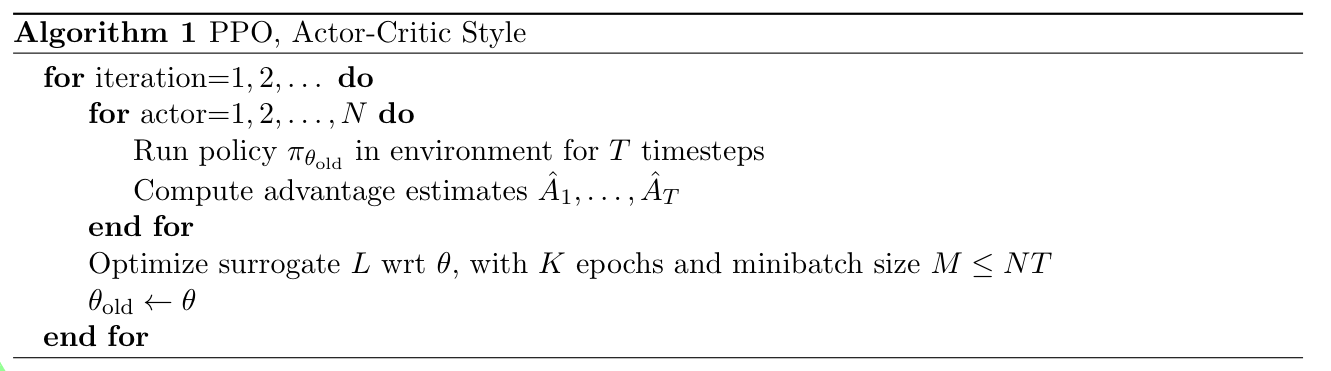

## Network

In [2]:
class PolicyValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # actor params
        self.actor_fc1 = nn.Linear(input_size, hidden_size)
        self.actor_fc2 = nn.Linear(hidden_size, output_size)

        # critic params
        self.critic_fc1 = nn.Linear(input_size, hidden_size)
        self.critic_fc2 = nn.Linear(hidden_size, hidden_size)
        self.critic_fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        actor_x = F.tanh(self.actor_fc1(x))
        policy = F.softmax(self.actor_fc2(actor_x), dim=-1)

        critic_x = F.tanh(self.critic_fc1(x))
        critic_x = F.tanh(self.critic_fc2(critic_x))
        value = self.critic_fc3(critic_x)

        return policy, value

## Agent

In [27]:
class PPOAgent:
    def __init__(self, action_space, n_actions, model, value_coeff, entropy_coeff, clip_eps, gamma, lr, lam=0.98):
        # model
        self.model = model

        # action params
        self.action_space = action_space
        self.n_actions = n_actions

        # coeffs • epsilon
        self.value_coeff = value_coeff
        self.entropy_coeff = entropy_coeff
        self.clip_eps = clip_eps

        # discount params
        self.gamma = gamma
        self.lam = lam

        # optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def get_action(self, state):
        policy, _ = self.model(state)

        # entropy bonus
        action_dist = Categorical(policy)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob.item()

    def clip_loss_ftn(self, advantage, old_prob, current_prob):
        ratio = current_prob / (old_prob + 1e-8)
        clipped_ratio = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps)
        surrogate1 = ratio * advantage
        surrogate2 = clipped_ratio * advantage
        return torch.min(surrogate1, surrogate2).mean()

    def cal_advantage(self, memory, lam=0.95):
        # set memory
        states, _, rewards, next_states, dones, _ = zip(*memory)

        states = torch.cat(states, dim=0)
        next_states = torch.cat(next_states, dim=0)
        rewards = torch.cat(rewards)
        dones = torch.cat(dones)

        # get values - next_values : GAE 계산을 위함
        with torch.no_grad():
            _, values = self.model(states)
            _, next_values = self.model(next_states)

        values = values.squeeze()
        next_values = next_values.squeeze()

        # Generalize Advantage Estimate(GAE) calculation
        # reversed list로 delta -> gae를 계산한다.
        advantage = []
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * next_values[t] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * lam * (1 - dones[t]) * gae
            advantage.insert(0, gae)

        return torch.tensor(advantage, dtype=torch.float32).unsqueeze(1)

    def train(self, memory, advantage):
        # set memory
        states, actions, rewards, next_states, dones, old_log_probs = zip(*memory)

        states = torch.cat(states, dim=0)
        actions = torch.cat(actions)
        next_states = torch.cat(next_states, dim=0)
        rewards = torch.cat(rewards)
        dones = torch.cat(dones)
        old_log_probs = torch.cat(old_log_probs).unsqueeze(1)

        # get current values
        self.model.train()
        current_policy, values = self.model(states)
        action_dist = Categorical(current_policy)                                # entropy bonus
        current_log_probs = action_dist.log_prob(actions.squeeze()).unsqueeze(1)
        current_probs = current_log_probs.exp()

        # 3 elements of loss : value_loss, clip_loss, entropy bonus
        with torch.no_grad():
            _, next_values = self.model(next_states)
            value_target = rewards + self.gamma * next_values.squeeze() * (1 - dones)

        value_loss = F.mse_loss(values.squeeze(), value_target)
        clip_loss = self.clip_loss_ftn(advantage, old_log_probs.exp(), current_probs)
        entropy = action_dist.entropy().mean()

        total_loss = -clip_loss + self.value_coeff * value_loss - self.entropy_coeff * entropy

        # back-propagation
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

        return total_loss.item()

In [28]:
# 환경 및 초기화
env = gym.make('CartPole-v1')
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

## Main

In [29]:
def main():
    env = gym.make('CartPole-v1')
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    network = PolicyValueNetwork(obs_dim, 128, n_actions)
    agent = PPOAgent(
        action_space=env.action_space,
        n_actions=n_actions,
        model=network,
        value_coeff=0.5,
        entropy_coeff=0.01,
        clip_eps=0.2,
        gamma=0.99,
        lr=1e-3
    )

    N_ITERATIONS = 1000
    N_STEPS = 200

    episode_rewards = []
    moving_avg_rewards = deque(maxlen=50)

    for episode in range(N_ITERATIONS):
        memory = []
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        done = False

        ep_reward = 0
        ep_len = 0

        for _ in range(N_STEPS):
            if done:
                break

            action, log_prob = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            memory.append([
                state,
                torch.tensor([[action]]),
                torch.tensor([reward], dtype=torch.float32),
                next_state,
                torch.tensor([done], dtype=torch.float32),
                torch.tensor([log_prob], dtype=torch.float32)
            ])
            state = next_state
            ep_reward += reward
            ep_len += 1

        episode_rewards.append(ep_reward)
        moving_avg_rewards.append(ep_reward)

        advantage = agent.cal_advantage(memory)
        loss = agent.train(memory, advantage)

        avg_reward = np.mean(moving_avg_rewards)
        print(f"Episode {episode:3d} | Loss: {loss: .4f} | Reward: {ep_reward:3.0f} | Avg(50): {avg_reward: .2f} | Len: {ep_len}")

    # 후에 결과 시각화
    plt.plot(episode_rewards, label='Episode Reward')
    plt.plot(np.convolve(episode_rewards, np.ones(50)/50, mode='valid'), label='Moving Avg (50)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid()
    plt.title('PPO Training Performance')
    plt.show()

## 실행

Episode   0 | Loss: -5.0604 | Reward:  13 | Avg(50):  13.00 | Len: 13
Episode   1 | Loss: -5.1366 | Reward:  13 | Avg(50):  13.00 | Len: 13
Episode   2 | Loss: -5.3493 | Reward:  15 | Avg(50):  13.67 | Len: 15
Episode   3 | Loss: -8.2409 | Reward:  28 | Avg(50):  17.25 | Len: 28
Episode   4 | Loss: -3.7739 | Reward:  11 | Avg(50):  16.00 | Len: 11
Episode   5 | Loss: -10.3978 | Reward:  45 | Avg(50):  20.83 | Len: 45
Episode   6 | Loss: -5.9579 | Reward:  18 | Avg(50):  20.43 | Len: 18
Episode   7 | Loss: -3.9408 | Reward:  13 | Avg(50):  19.50 | Len: 13
Episode   8 | Loss: -6.4434 | Reward:  22 | Avg(50):  19.78 | Len: 22
Episode   9 | Loss: -5.1571 | Reward:  18 | Avg(50):  19.60 | Len: 18
Episode  10 | Loss: -4.4046 | Reward:  16 | Avg(50):  19.27 | Len: 16
Episode  11 | Loss: -4.8905 | Reward:  18 | Avg(50):  19.17 | Len: 18
Episode  12 | Loss: -7.2733 | Reward:  27 | Avg(50):  19.77 | Len: 27
Episode  13 | Loss: -9.5390 | Reward:  44 | Avg(50):  21.50 | Len: 44
Episode  14 | Loss:

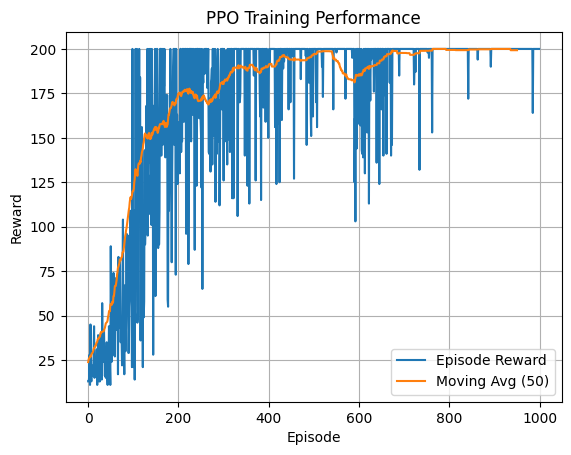

In [30]:
main()